Testing the voting scheme on a -ve mode file

In [115]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
from scipy import stats

base_dir = '/Users/simon/git/ms1fun/'
sys.path.append(base_dir + 'code')
sys.path.append(base_dir + 'dbs')

from corr_cluster import Peak,BetaLike,CorrCluster
from formula import Formula
import pylab as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
files = []

prefix = '/Users/simon/Dropbox/Bioresearch/Meta_clustering/ms1fundata/Beer/NegativeMode/Beer_3_full/csv/'
filename = 'Beer_3_Full1'
files.append((prefix,filename,False))

prefix = '/Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/urine/neg/csv/'
filename = 'Urine_37_fullscan1_NEG'
files.append((prefix,filename,False))

prefix = '/Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/standards/neg/csv/'
filename = 'batch1_Std_1_1'
files.append((prefix,filename,True))

filename = 'batch1_Std_1_2'
files.append((prefix,filename,True))

filename = 'batch1_Std_2_1'
files.append((prefix,filename,True))

filename = 'batch1_Std_2_2'
files.append((prefix,filename,True))


In [117]:
import transformation
transformations = transformation.load_from_file(base_dir + 'dbs/neg_transformations.yml')
print "Loaded " + str(len(transformations)) + " transformations"

Loaded 80 transformations


In [118]:
bl = BetaLike()
clusterings = {}
for f in files:

    filename = f[1]
    prefix = f[0]
    print "Running file " + filename
    csvfile = prefix + filename + '.csv'
    matfile = prefix + filename + '.corr.mat'
    signalfile = prefix + filename + '.peakml.signal'
    # Simon is an idiot...remember to change 'correct = True' or 'correct = False' 
    # coc = CorrCluster(bl,csvfile,matfile,signal_file=signalfile,greedy_thresh=0.7,correct=True)
    coc = CorrCluster(bl,csvfile,matfile,signal_file=signalfile,greedy_thresh=0.7,correct=f[2])
    clusterings[filename] = coc

Running file Beer_3_Full1
1356.4
Loaded 5668 peaks
Reading shape correlations from /Users/simon/Dropbox/Bioresearch/Meta_clustering/ms1fundata/Beer/NegativeMode/Beer_3_full/csv/Beer_3_Full1.corr.mat
Greedy clustering done, resulting in 947 clusters
Running file Urine_37_fullscan1_NEG
138
Loaded 6662 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/urine/neg/csv/Urine_37_fullscan1_NEG.corr.mat
Greedy clustering done, resulting in 1128 clusters
Running file batch1_Std_1_1
1391.708618164
Loaded 5618 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/standards/neg/csv/batch1_Std_1_1.corr.mat
Greedy clustering done, resulting in 1454 clusters
Running file batch1_Std_1_2
Loaded 5736 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/standards/neg/csv/batch1_Std_1_2.corr.mat
Greedy clustering done, resulting in 1442 clusters
Running file batch1_Std_2_1

In [119]:
from voter import Voter,PeakGroup

groups = {}
for f in files:
    v = Voter(transformations)
    filename = f[1]
    print "Performing voting on file {}".format(filename)
    file_groups = []
    for cluster in clusterings[filename].clusters:
        file_groups += v.make_groups(cluster.members)
    groups[filename] = file_groups

Performing voting on file Beer_3_Full1
Performing voting on file Urine_37_fullscan1_NEG
Performing voting on file batch1_Std_1_1
Performing voting on file batch1_Std_1_2
Performing voting on file batch1_Std_2_1
Performing voting on file batch1_Std_2_2


In [120]:
from databases import Standards
st = Standards()
all_hits = {}
for f in files:
    filename = f[1]
    all_hits[filename] = st.get_group_hits(groups[filename],use_max_vote = True,mtol=10,rttol=50)

    

In [121]:
# Sort the groups according to votes (top ones first)
global_adduct_counts = {}
global_transformation_counts = {}
global_fragment_counts = {}
for f in files:
    filename = f[1]
    outpre = 'output/neg/' + filename

    temp_groups = sorted(groups[filename],key = lambda x:x.vote,reverse=True)
    outfile = outpre + '_by_vote.txt'
    

    with open(outfile,'w') as f:
        for i,group in enumerate(temp_groups):
            line = "vote: {}, M: {}\n".format(group.vote,group.M)
            f.write(line)
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
            f.write(head_line)
            for (peak,transformation,transmass) in sorted(group.members,key = lambda x: x[1].vote,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                f.write(line)
            f.write('\n')
            
    temp_groups = sorted(groups[filename],key = lambda x:x.M)
    outfile = outpre + '_by_M.txt'
    
    with open(outfile,'w') as f:
        for i,group in enumerate(temp_groups):
            line = "vote: {}, M: {}\n".format(group.vote,group.M)
            f.write(line)
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
            f.write(head_line)
            for (peak,transformation,transmass) in sorted(group.members,key = lambda x: x[1].vote,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                f.write(line)
            f.write('\n')

    with open(outpre + '_matched_std.txt','w') as f:
        for mol in all_hits[filename]:
            group = all_hits[filename][mol]
            line = "{} (vote={})\n".format(mol,group.vote)
            f.write(line)
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
            f.write(head_line)
            for (peak,transformation,transmass) in sorted(group.members,key = lambda x: x[1].vote,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                f.write(line)
            f.write('\n')


    include_singletons = False
    trans_counts = {}
    tot = 0
    for tr in transformations:
        trans_counts[tr] = 0
    for group in groups[filename]:
        if not include_singletons:
            if len(group.members) == 1:
                continue
        for p,t,_ in group.members:
            trans_counts[t] += 1
            tot += 1

    with open(outpre + '_tran_counts.txt','w') as f:
        for tr in sorted(transformations,key = lambda x: x.vote, reverse=True):
            line = "{},{},{:.4f}\n".format(tr,trans_counts[tr],trans_counts[tr]/(1.0*tot))
            f.write(line)
            
    # output the counts of particular adducts / fragments
    frag_counts = {}
    adduct_counts = {}
    adduct_tot = 0
    frag_tot = 0
    for tr in transformations:
        for f in tr.fragments:
            if not f in frag_counts:
                frag_counts[f] = 0
        for a in tr.adducts:
            if not a in adduct_counts:
                adduct_counts[a] = 0
                
    for group in groups[filename]:
        for p,t,_ in group.members:
            for f in t.fragments:
                frag_counts[f] += 1
                frag_tot += 1
            for a in t.adducts:
                adduct_counts[a] += 1
                adduct_tot += 1
                
    global_adduct_counts[filename] = adduct_counts
    global_fragment_counts[filename] = frag_counts
    global_transformation_counts[filename] = trans_counts
                
    with open(outpre + '_adduct_counts.txt','w') as f:
        for a in adduct_counts:
            line = "{},{},{:.4f}\n".format(a,adduct_counts[a],adduct_counts[a]/(1.0*adduct_tot))
            f.write(line)
    
    with open(outpre + '_fragment_counts.txt','w') as f:
        for fr in frag_counts:
            line = "{},{},{:.4f}\n".format(fr,frag_counts[fr],frag_counts[fr]/(1.0*frag_tot))
            f.write(line)

            

Write out files of global adducts, fragments and transformations, to save excel wrangling

In [122]:
# Note this just does percentages
# Note 2 - for fragments, this is normalised according to things that have fragments
all_frags = []
for fi in global_fragment_counts:
    frags = global_fragment_counts[fi].keys()
    for fr in frags:
        if not fr in all_frags:
            all_frags.append(fr)

all_files = global_fragment_counts.keys()
totals = {}
for filename in all_files:
    tot = 0
    for fr in global_fragment_counts[filename]:
        tot += global_fragment_counts[filename][fr]
    totals[filename] = tot
            
        
frag_perc = {}
for filename in all_files:
    frag_perc[filename] = []
    for fr in all_frags:
        frag_perc[filename].append(global_fragment_counts[filename][fr]/(1.0*totals[filename]))
            
    
with open('output/neg/global_frags.txt','w') as f:
    st = "Fragment"
    for filename in all_files:
        st += ',{}'.format(filename)
    f.write(st+'\n')
    for fr in all_frags:
        st = fr
        for filename in all_files:
            st += ",{}".format(global_fragment_counts[filename][fr]/(1.0*totals[filename]))
        f.write(st+'\n')
        
        

        
# ADDUCTS
all_adducts = []
for fi in global_adduct_counts:
    adds = global_adduct_counts[fi].keys()
    for ad in adds:
        if not ad in all_adducts:
            all_adducts.append(ad)

all_files = global_adduct_counts.keys()
totals = {}
for filename in all_files:
    tot = 0
    for ad in global_adduct_counts[filename]:
        tot += global_adduct_counts[filename][ad]
    totals[filename] = tot
            
        
adduct_perc = {}
for filename in all_files:
    adduct_perc[filename] = []
    for ad in all_adducts:
        adduct_perc[filename].append(global_adduct_counts[filename][ad]/(1.0*totals[filename])) 
        
with open('output/neg/global_adducts.txt','w') as f:
    st = "Adduct"
    for filename in all_files:
        st += ',{}'.format(filename)
    f.write(st+'\n')
    for ad in all_adducts:
        st = ad
        for filename in all_files:
            st += ",{}".format(global_adduct_counts[filename][ad]/(1.0*totals[filename]))
        f.write(st+'\n')
        
        
        
# TRANSFORMATIONS
all_trans = []
for fi in global_transformation_counts:
    adds = global_transformation_counts[fi].keys()
    for tr in adds:
        if not tr in all_trans:
            all_trans.append(tr)

all_files = global_transformation_counts.keys()
totals = {}
for filename in all_files:
    tot = 0
    for tr in global_transformation_counts[filename]:
        tot += global_transformation_counts[filename][tr]
    totals[filename] = tot

trans_perc = {}
all_trans = global_transformation_counts[fi].keys()
all_trans = sorted(all_trans,key=lambda x: x.vote,reverse=True)
for filename in all_files:
    trans_perc[filename] = []
    for tr in all_trans:
        trans_perc[filename].append(global_transformation_counts[filename][tr]/(1.0*totals[filename]))


with open('output/neg/global_transformations.txt','w') as f:
    st = "Transformation"
    for filename in all_files:
        st += ',{}'.format(filename)
    f.write(st+'\n')
    for tr in sorted(all_trans,key = lambda x: x.vote,reverse=True):
        st = tr.name
        for filename in all_files:
            st += ",{}".format(global_transformation_counts[filename][tr]/(1.0*totals[filename]))
        f.write(st+'\n')

Make a clustered bar of fragments

[0, 1, 2]
0 Beer_3_Full1
1 batch1_Std_1_1
2 batch1_Std_1_2
3 batch1_Std_2_2
4 batch1_Std_2_1
5 Urine_37_fullscan1_NEG


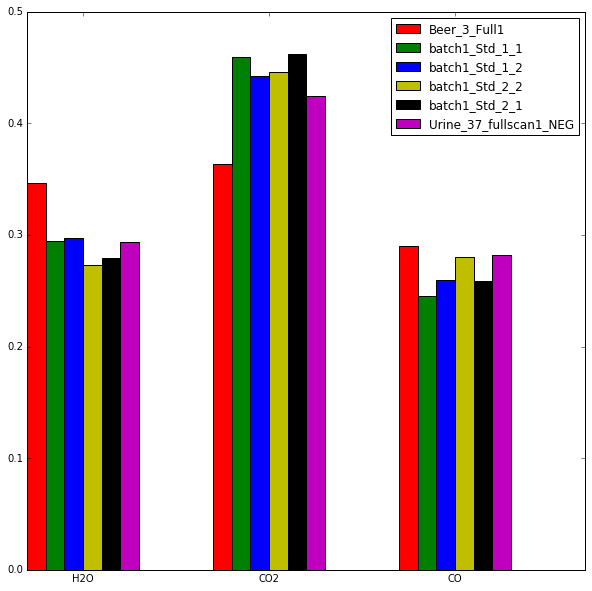

In [123]:
plt.figure(figsize=(10,10))
plt.size((10,10))
N = len(all_frags)
posn = range(N)
print posn
nfiles = len(all_files)
width = 0.1
cols = ['r','g','b','y','k','m']
rects = []
for i,filename in enumerate(all_files):
    print i,filename
    rects.append(plt.bar([p+width*i for p in posn],frag_perc[filename],width=width,color=cols[i]))
plt.legend(rects,all_files)
plt.xticks([p+width*nfiles/2 for p in posn],all_frags)
plt.savefig('output/neg/frag_bars.png',dpi=200)

Make a clustered bar of adducts

[0, 1, 2, 3]
0 Beer_3_Full1
1 batch1_Std_1_1
2 batch1_Std_1_2
3 batch1_Std_2_2
4 batch1_Std_2_1
5 Urine_37_fullscan1_NEG
['CH2O2', '-H', 'NH3', 'ACN']
[0, 1, 2]
0 Beer_3_Full1
1 batch1_Std_1_1
2 batch1_Std_1_2
3 batch1_Std_2_2
4 batch1_Std_2_1
5 Urine_37_fullscan1_NEG


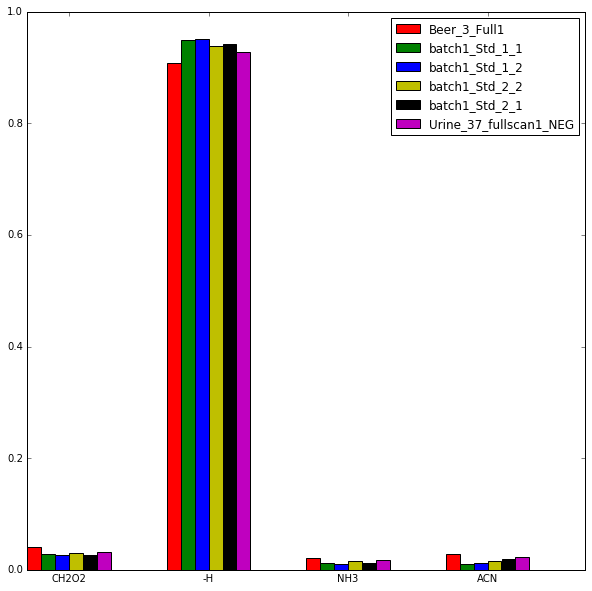

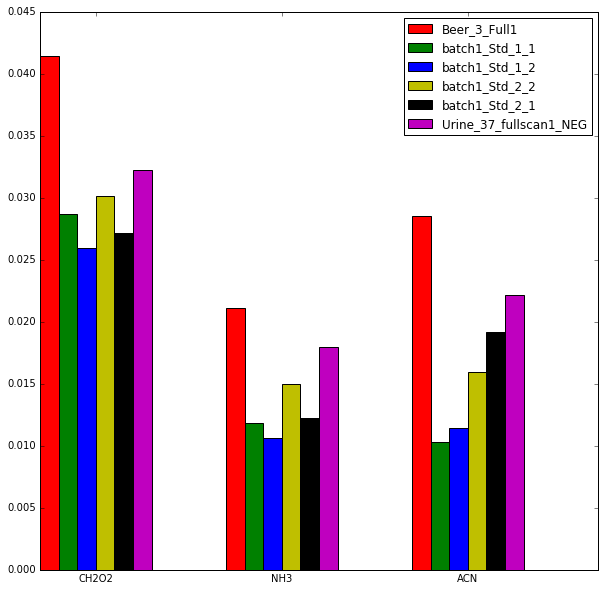

In [124]:
plt.figure(figsize=(10,10))
plt.size((10,10))
N = len(all_adducts)
posn = range(N)
print posn
nfiles = len(all_files)
width = 0.1
cols = ['r','g','b','y','k','m']
rects = []
for i,filename in enumerate(all_files):
    print i,filename
    rects.append(plt.bar([p+width*i for p in posn],adduct_perc[filename],width=width,color=cols[i]))
plt.legend(rects,all_files)
plt.xticks([p+width*nfiles/2 for p in posn],all_adducts)

import copy
# Repeat without M+H
adduct_perc2 = copy.deepcopy(adduct_perc)
all_adducts2 = copy.deepcopy(all_adducts)
print all_adducts
mhi = all_adducts2.index("-H")
del all_adducts2[mhi]
for fi in adduct_perc2:
    del adduct_perc2[fi][mhi]
    
plt.figure(figsize=(10,10))
plt.size((10,10))
N = len(all_adducts2)
posn = range(N)
print posn
nfiles = len(all_files)
width = 0.1
cols = ['r','g','b','y','k','m']
rects = []
for i,filename in enumerate(all_files):
    print i,filename
    rects.append(plt.bar([p+width*i for p in posn],adduct_perc2[filename],width=width,color=cols[i]))
plt.legend(rects,all_files)
plt.xticks([p+width*nfiles/2 for p in posn],all_adducts2)
plt.savefig('output/neg/add_bars.png',dpi=200)

Make a clustered bar of all transformations

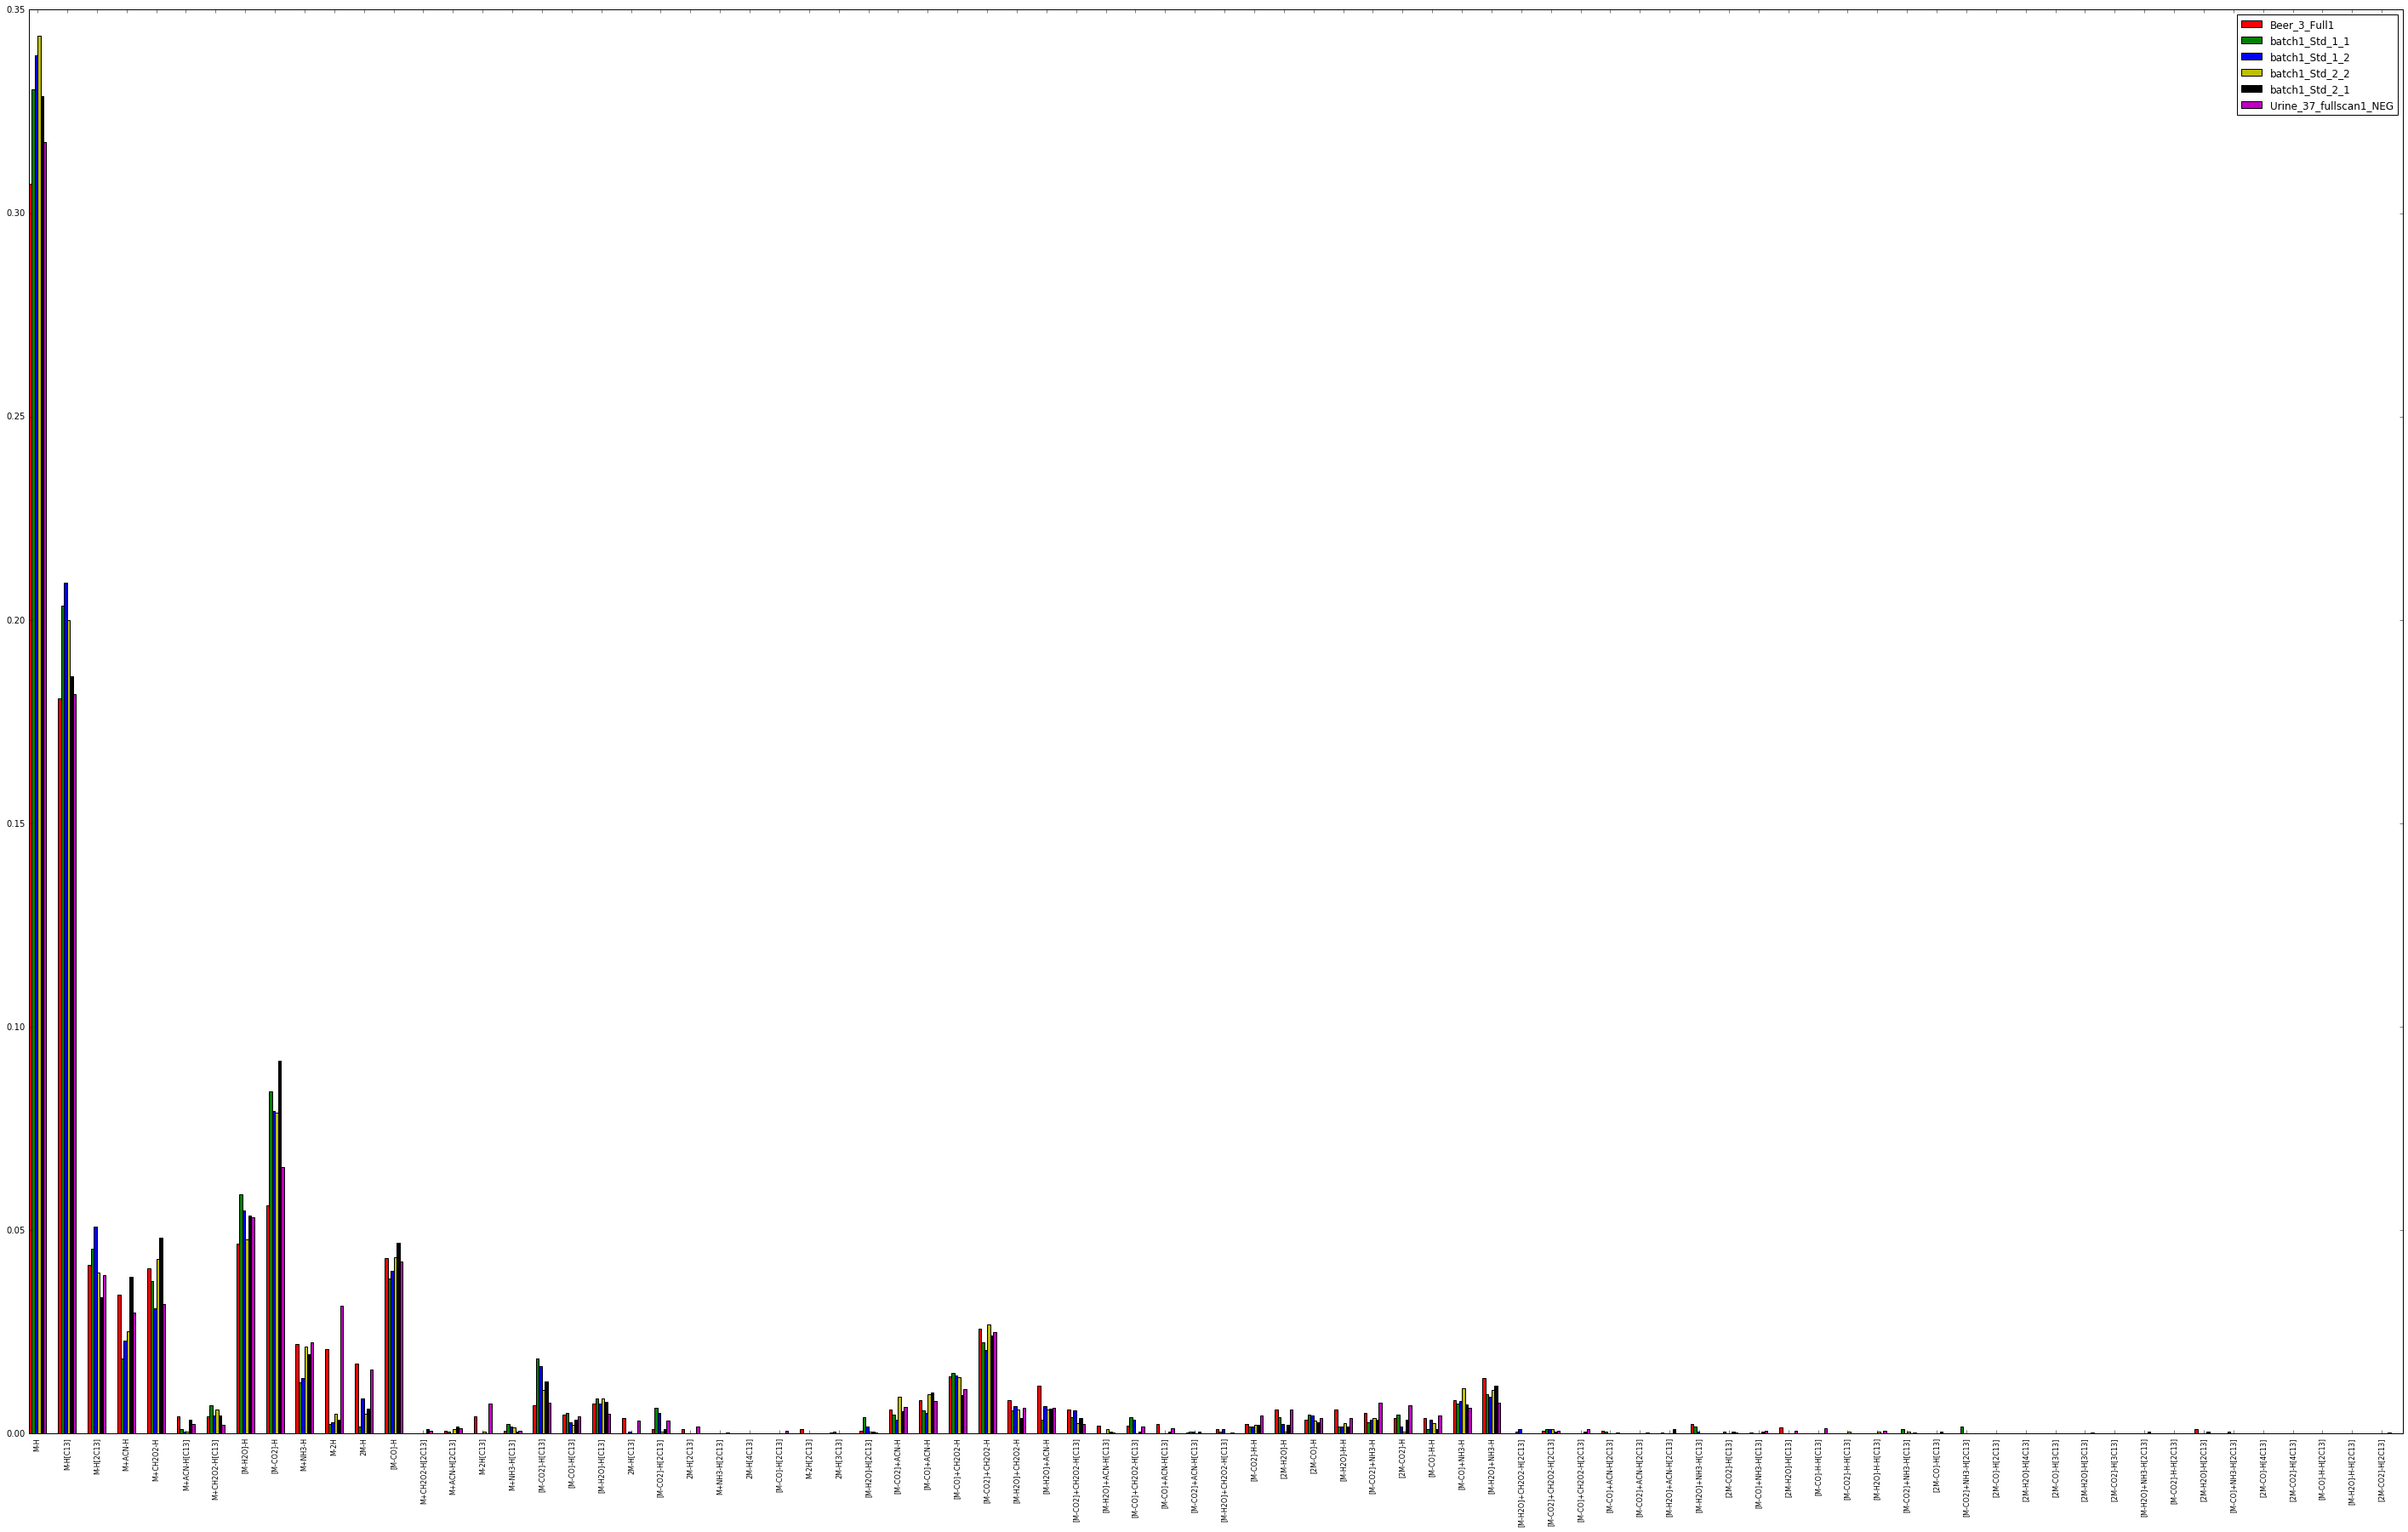

In [125]:
plt.figure(figsize=(50,30))
plt.size((10,10))
N = len(all_trans)
posn = range(N)
nfiles = len(all_files)
width = 0.1
cols = ['r','g','b','y','k','m']
rects = []
for i,filename in enumerate(all_files):
    rects.append(plt.bar([p+width*i for p in posn],trans_perc[filename],width=width,color=cols[i]))
plt.legend(rects,all_files)
plt.xticks([p+width*nfiles/2 for p in posn],all_trans,rotation=90,fontsize=8)
plt.savefig('output/neg/trans_bars.png',dpi=200)

Beer_3_Full1
4063 groups, consisting of 5668 peaks
3116 singleton groups (77% of groups, 55% of peaks)
1733 peaks under threshold (1e+05), 31% of peaks
	1263 of which are singletons (73%)
470 peaks below the threshold in groups of size > 1
51 groups where the most intense peak is below the threshold (avg size = 2.04 avg vote = 1.39)
Test between intensity and vote for all peaks: corr coef = 0.413975228981, p-value = 1.30471430023e-233
Test between maximum group intensity and vote: corr coef = 0.64140228042, p-value = 0.0


batch1_Std_1_1
4534 groups, consisting of 5618 peaks
3884 singleton groups (86% of groups, 69% of peaks)
3635 peaks under threshold (1e+05), 65% of peaks
	2887 of which are singletons (79%)
748 peaks below the threshold in groups of size > 1
145 groups where the most intense peak is below the threshold (avg size = 2.14 avg vote = 1.41)
Test between intensity and vote for all peaks: corr coef = 0.441219161152, p-value = 2.24025609802e-266
Test between maximum group in

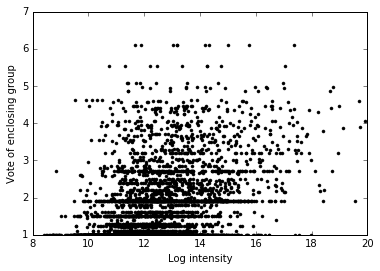

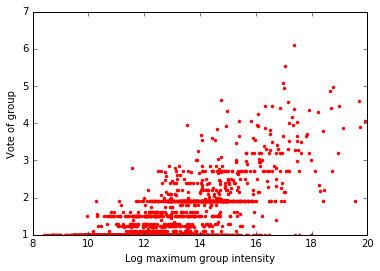

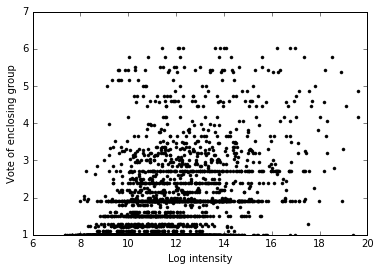

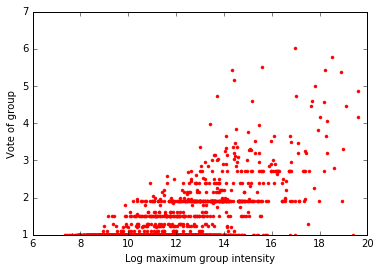

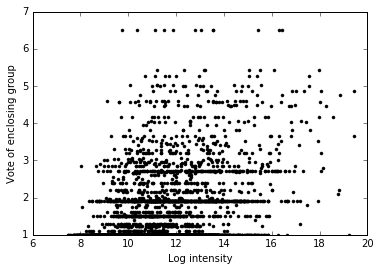

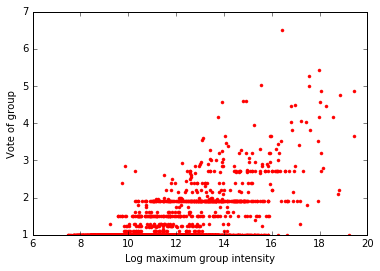

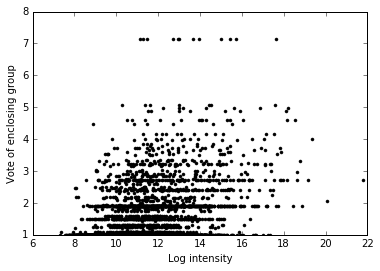

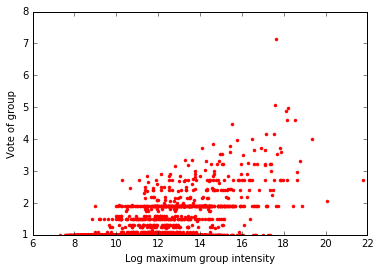

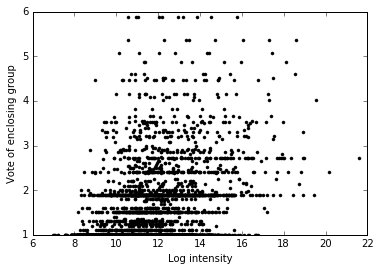

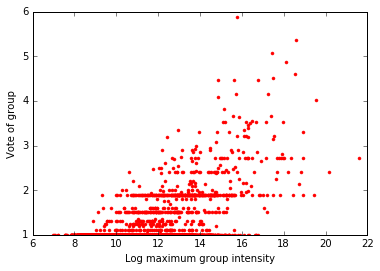

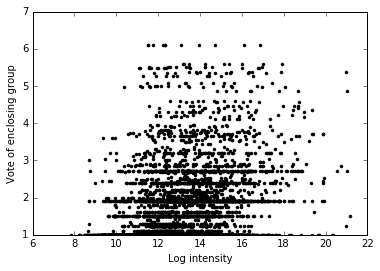

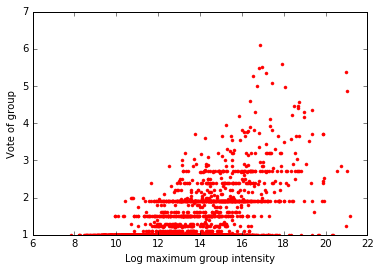

In [126]:
import helper_functions
for filename in groups:
    print filename
    helper_functions.collect_group_stats(groups[filename])
    print
    print

HMDB Analsysis on Urine
==

Urine_37_fullscan1_NEG
Number of raw hits (i.e. comparing all peaks): 2552 (38% of peaks)
Number of group hits (i.e. hits on group Ms): 1900 (39% of groups)


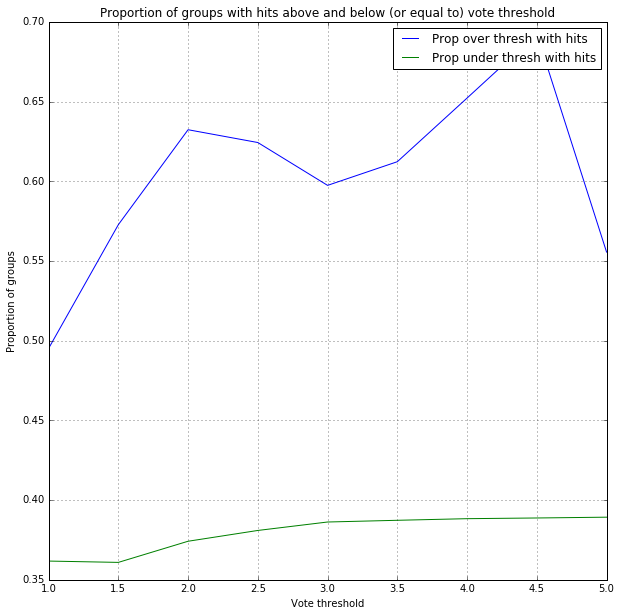

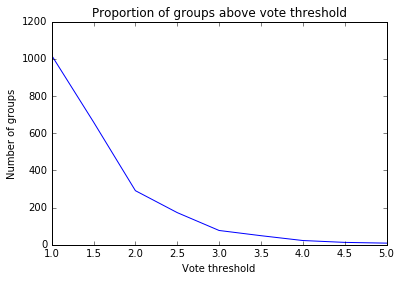

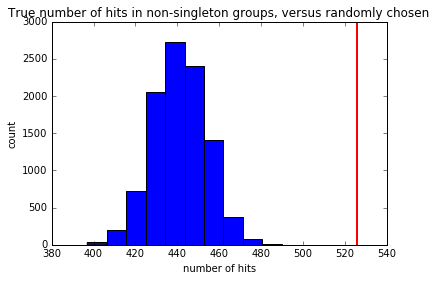

In [127]:
import helper_functions
filename = files[1][1]
print filename
helper_functions.hmdb_analysis(groups[filename],mode = 'neg',mtol=10,filename = filename,v_thresh=np.arange(1.0,5.5,0.5))

HMDB analysis on beer - just to see!
==


Beer_3_Full1
Number of raw hits (i.e. comparing all peaks): 2589 (46% of peaks)
Number of group hits (i.e. hits on group Ms): 1877 (46% of groups)


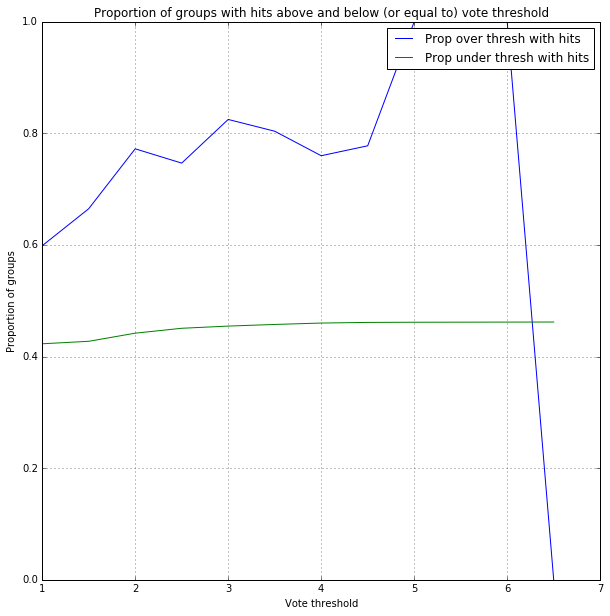

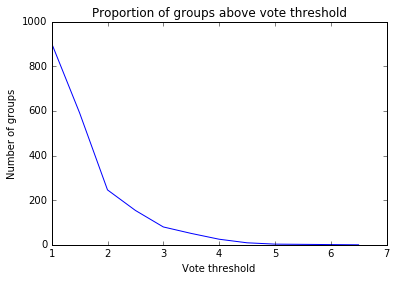

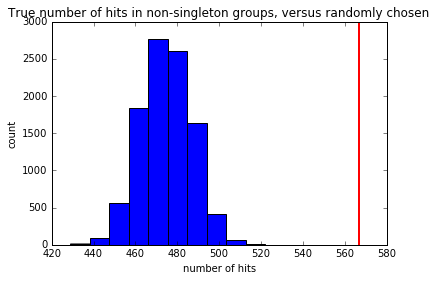

In [128]:
beerfile = files[0][1]
print beerfile
helper_functions.hmdb_analysis(groups[beerfile],mode='neg',filename=beerfile,mtol=10)

Standards analysis
==


batch1_Std_2_1
Number of raw hits (i.e. comparing all peaks): 14 (0% of peaks)
Number of group hits (i.e. hits on group Ms): 10 (0% of groups)


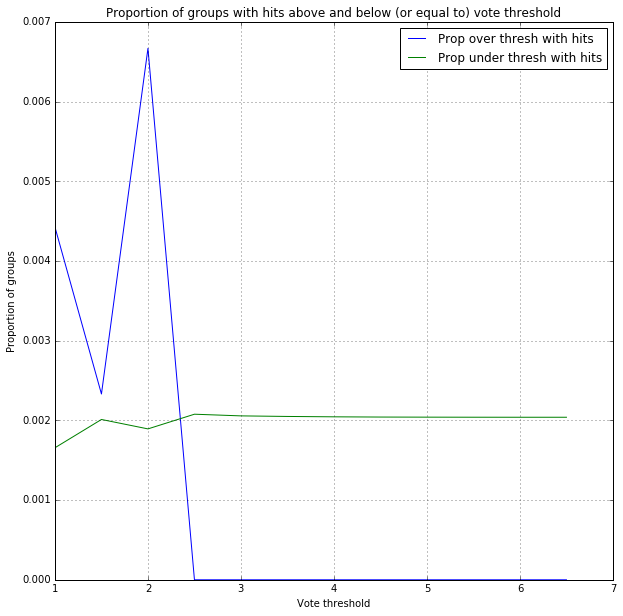

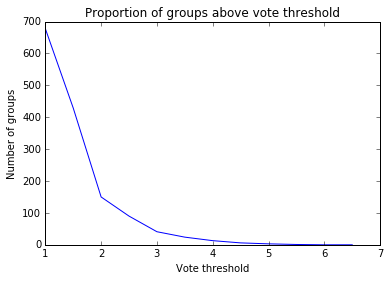

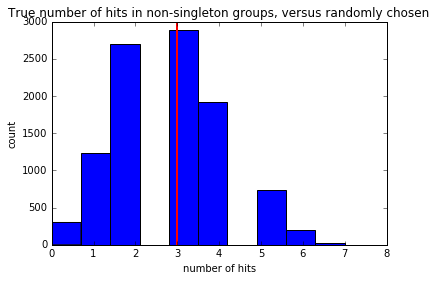

In [129]:
stdfile = files[4][1]
print stdfile
helper_functions.standard_analysis(groups[stdfile],filename=stdfile,mode='neg',mtol=10,rttol=50)